In [153]:
#Si importano le librerie principali
from keras.callbacks import TensorBoard
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
import os
from pathlib import Path
import itertools
from sklearn.utils import shuffle
from keras import Sequential
from keras.optimizers import SGD,Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report,confusion_matrix
import ipywidgets as widgets
import io
from keras.layers import Flatten,Dense,BatchNormalization,Activation,Dropout
from keras.utils import to_categorical
from PIL import Image
from IPython.display import display,clear_output
from warnings import filterwarnings
from tensorflow import keras 
from tensorflow.keras import layers

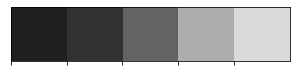

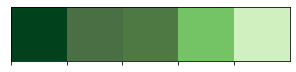

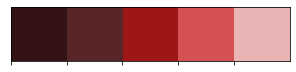

In [154]:
#Si definiscono array di colori che vengono raggruppati in scuri, rossi e verdi e utilizzati in seguito
colors_dark = ["#1F1F1F", "#313131", '#636363', '#AEAEAE', '#DADADA']
colors_red = ["#331313", "#582626", '#9E1717', '#D35151', '#E9B4B4']
colors_green = ['#01411C','#4B6F44','#4F7942','#74C365','#D0F0C0']

sns.palplot(colors_dark)
sns.palplot(colors_green)
sns.palplot(colors_red)

In [140]:
labels = ['glioma_tumor','meningioma_tumor','no_tumor','pituitary_tumor']

In [141]:
#Si iniziano a leggere tutte le immagini e ad aggiungerle tramite una lista
#e si convertono in un numpy array dopo averle rese tutte della stessa grandezza
X_train = []
y_train = []
X_test = []
y_test = []
image_size = 150
for i in labels:
    folderPath = os.path.join('../Desktop/terzo anno/tesi/Brain-Tumor-Classification-DataSet-master','Training',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        X_train.append(img)
        y_train.append(i)
#opencv permette di di leggere l'immagine e restituisce un numpy array
for i in labels:
    folderPath = os.path.join('../Desktop/terzo anno/tesi/Brain-Tumor-Classification-DataSet-master','Testing',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size,image_size))
        X_train.append(img)
        y_train.append(i)
#si convertono in numpy array
X_train = np.array(X_train)
y_train = np.array(y_train)


100%|██████████████████████████████████████████████████████████████████████████████████| 74/74 [00:01<00:00, 52.85it/s]


In [142]:
X_train, y_train = shuffle(X_train,y_train, random_state=101)

In [143]:
X_train.shape

(3264, 150, 150, 3)

In [144]:
X_train,X_test, y_train, y_test = train_test_split(X_train, y_train,train_size=0.9,random_state=101)

In [145]:
X_test.shape

(327, 150, 150, 3)

In [146]:
X_train[5]

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)

In [147]:
X_test.shape
y_test.shape

(327,)

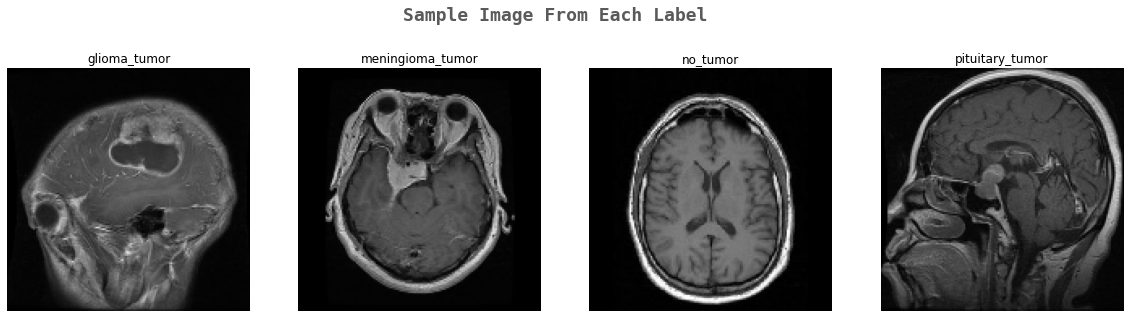

In [148]:
k=0
fig, ax = plt.subplots(1,4,figsize=(20,20))
fig.text(s='Sample Image From Each Label',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=0.62,x=0.4,alpha=0.8)
for i in labels:
    j=0
    while True :
        if y_train[j]==i:
            ax[k].imshow(X_train[j])
            ax[k].set_title(y_train[j])
            ax[k].axis('off')
            k+=1
            break
        j+=1

In [149]:
#faccio un rescaling
X_train_scaled = X_train / 255
X_test_scaled = X_test / 255

In [150]:
X_train_scaled.shape

(2937, 150, 150, 3)

In [30]:
y_train = y_train.reshape(-1,)
y_test = y_test.reshape(-1,)

In [151]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Conv2D,Flatten,MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
from keras.regularizers import l2

In [152]:
#Si definisce il modello per fare il training della rete neurale.
#Si utilizzano 4 strati di convoluzione intervallati da fasi di Max-Pooling.
#Si utilizza la relu come funzione di attivazione e dei filtri di dimensione 3x3.
#Successivamente si va a fare un flattening dell'input e da CNN si passa ad ANN.
#Si utilizza una dimensione extra none che serve in quanto la batch_size può variare.
#Con gli strati Dense si va a lavorare con una rete fully-connected come nelle ANN semplici. 
#La classificazione usa la funzione softmax, perchè permette di fare previsioni
#per più di due categorie
cnn = Sequential()
cnn.add(Conv2D(32, (3, 3), activation="relu", input_shape=(image_size,image_size, 3)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))
cnn.add(Conv2D(32, (3, 3), activation="relu", input_shape=(image_size,image_size, 3)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))
cnn.add(Conv2D(32, (3, 3), activation="relu", input_shape=(image_size,image_size, 3)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))
cnn.add(Conv2D(64, (3, 3), activation="relu", input_shape=(image_size,image_size, 3)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))
cnn.add(Conv2D(64, (3, 3), activation="relu", input_shape=(image_size,image_size, 3)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))
cnn.add(Dropout(0.5))
cnn.add(Flatten())
cnn.add(Dense(activation = 'relu', units = 128))
cnn.add(Dense(activation = 'relu', units = 64))
cnn.add(Dense(activation = 'softmax', units = 4))
cnn.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics =['accuracy'])

In [44]:
cnn.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 72, 72, 32)        9248      
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 34, 34, 32)        9248      
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 17, 17, 32)        0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 15, 15, 64)       

In [35]:
y_train_new = []
for i in y_train:
    y_train_new.append(labels.index(i))
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)


y_test_new = []
for i in y_test:
    y_test_new.append(labels.index(i))
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

In [69]:
cnn.fit(X_train_scaled, y_train, epochs = 30)

Epoch 1/30
92/92 [==============================] - 29s 319ms/step - loss: 1.2727 - accuracy: 0.3837
Epoch 2/30
92/92 [==============================] - 29s 314ms/step - loss: 1.0967 - accuracy: 0.5145
Epoch 3/30
92/92 [==============================] - 29s 320ms/step - loss: 0.8897 - accuracy: 0.6343
Epoch 4/30
92/92 [==============================] - 30s 321ms/step - loss: 0.7709 - accuracy: 0.6898
Epoch 5/30
92/92 [==============================] - 30s 331ms/step - loss: 0.6856 - accuracy: 0.7259
Epoch 6/30
92/92 [==============================] - 34s 365ms/step - loss: 0.6055 - accuracy: 0.7606
Epoch 7/30
92/92 [==============================] - 34s 367ms/step - loss: 0.5447 - accuracy: 0.7937
Epoch 8/30
92/92 [==============================] - 33s 357ms/step - loss: 0.4728 - accuracy: 0.8189
Epoch 9/30
92/92 [==============================] - 32s 345ms/step - loss: 0.3971 - accuracy: 0.8495
Epoch 10/30
92/92 [==============================] - 33s 363ms/step - loss: 0.3790 - accura

In [76]:
cnn.evaluate(X_test_scaled, y_test) #se fosse venuto 0,6 era overfitting

11/11 [==============================] - 1s 55ms/step - loss: 0.2679 - accuracy: 0.9388


[0.267866849899292, 0.9388379454612732]

In [77]:
prediction = cnn.predict(X_test_scaled)
#ritorna l'indice della categoria la cui probabilità è massima
score = tf.nn.softmax(prediction[0])
print(score)
np.argmax(score)

tf.Tensor([0.1749766  0.17530088 0.17497554 0.47474697], shape=(4,), dtype=float32)


3

In [46]:
data_augmentation = keras.Sequential([
        
        layers.experimental.preprocessing.RandomFlip("horizontal", input_shape= (image_size,image_size,3)),
        #layers.experimental.preprocessing.RandomRotation(factor=(-0.2,0.2))
    ])

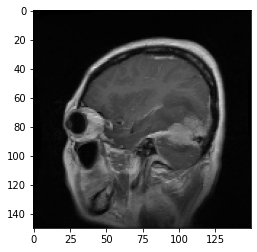

In [110]:
plt.imshow(X_train[20])

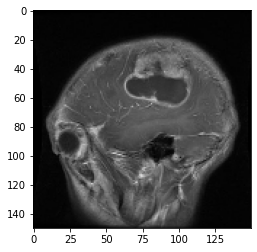

In [111]:
#come si può vedere è stato fatto uno zoom
plt.imshow(data_augmentation(X_train)[0].numpy().astype("uint8"))

In [47]:
#Si definisce il modello per fare il training della rete neurale.
#Si utilizzano 4 strati di convoluzione intervallati da fasi di Max-Pooling.
#Si utilizza la relu come funzione di attivazione e dei filtri di dimensione 3x3.
#Successivamente si va a fare un flattening dell'input e da CNN si passa ad ANN.
#Si utilizza una dimensione extra none che serve in quanto la batch_size può variare.
#Con gli strati Dense si va a lavorare con una rete fully-connected come nelle ANN semplici. 
#La classificazione usa la funzione softmax, perchè permette di fare previsioni
#per più di due categorie
cnn = Sequential([data_augmentation])
cnn.add(Conv2D(32, (3, 3), activation="relu", input_shape=(image_size,image_size, 3)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))
cnn.add(Conv2D(32, (3, 3), activation="relu", input_shape=(image_size,image_size, 3)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))
cnn.add(Conv2D(32, (3, 3), activation="relu", input_shape=(image_size,image_size, 3)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))
cnn.add(Conv2D(64, (3, 3), activation="relu", input_shape=(image_size,image_size, 3)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))
cnn.add(Conv2D(64, (3, 3), activation="relu", input_shape=(image_size,image_size, 3)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))
cnn.add(Dropout(0.5))
cnn.add(Flatten())
cnn.add(Dense(activation = 'relu', units = 128))
cnn.add(Dense(activation = 'relu', units = 64))
cnn.add(Dense(activation = 'softmax', units = 4))
cnn.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics =['accuracy'])

In [48]:
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint("effnet.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 2, min_delta = 0.001,
                              mode='auto',verbose=1)
cnn.fit(X_train_scaled, y_train, epochs = 30, validation_split = 0.1, batch_size=32,callbacks=[tensorboard, checkpoint, reduce_lr])

Epoch 1/30
75/75 [==============================] - ETA: 0s - loss: 1.3551 - accuracy: 0.3137
Epoch 00001: val_accuracy improved from -inf to 0.48302, saving model to effnet.h5
75/75 [==============================] - 51s 686ms/step - loss: 1.3551 - accuracy: 0.3137 - val_loss: 1.2537 - val_accuracy: 0.4830
Epoch 2/30
75/75 [==============================] - ETA: 0s - loss: 1.1967 - accuracy: 0.4672
Epoch 00002: val_accuracy improved from 0.48302 to 0.51321, saving model to effnet.h5
75/75 [==============================] - 38s 506ms/step - loss: 1.1967 - accuracy: 0.4672 - val_loss: 1.1096 - val_accuracy: 0.5132
Epoch 3/30
75/75 [==============================] - ETA: 0s - loss: 1.0757 - accuracy: 0.5315
Epoch 00003: val_accuracy improved from 0.51321 to 0.58491, saving model to effnet.h5
75/75 [==============================] - 38s 510ms/step - loss: 1.0757 - accuracy: 0.5315 - val_loss: 0.9747 - val_accuracy: 0.5849
Epoch 4/30
75/75 [==============================] - ETA: 0s - loss:

In [49]:
cnn.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_9 (Sequential)    (None, 150, 150, 3)       0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 72, 72, 32)        9248      
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 34, 34, 32)        9248      
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 17, 17, 32)      

In [86]:
#se non si mette niente la batch size di default è 32
cnn.evaluate(X_test_scaled, y_test) #se fosse venuto 0,6 era overfitting

11/11 [==============================] - 1s 49ms/step - loss: 0.2655 - accuracy: 0.9174


[0.265461802482605, 0.9174311757087708]

In [72]:
cnn.save("my_h5_model.h5")


In [73]:
reconstructed_model = keras.models.load_model("my_h5_model.h5")
# Let's check:
np.testing.assert_allclose(
    cnn.predict(X_test_scaled), reconstructed_model.predict(X_test_scaled)
)

# The reconstructed model is already compiled and has retained the optimizer
# state, so training can resume:
reconstructed_model.fit(X_test_scaled, y_test)


10/10 [==============================] - 4s 410ms/step - loss: 0.4179 - accuracy: 0.8571


In [101]:
y_train.shape

(2937, 4)

In [88]:
X_train_scaled.shape


(2937, 150, 150, 3)

In [89]:
pred = cnn.predict(X_test_scaled)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)
print(pred)
print(y_test_new)

[3 2 0 1 3 0 2 3 1 1 2 0 0 1 1 3 3 2 3 2 3 0 1 1 1 3 1 3 3 1 1 3 0 1 3 2 3
 2 0 2 2 2 3 1 1 3 0 1 3 1 2 0 3 3 2 3 0 3 1 1 1 1 1 0 3 3 3 0 3 0 1 0 3 1
 0 2 0 2 2 1 1 2 3 3 0 0 1 3 2 1 1 3 0 1 0 1 0 2 3 1 1 0 2 2 3 3 3 0 0 3 1
 1 3 0 3 0 3 3 2 1 0 1 3 0 3 3 1 3 3 0 1 0 1 3 2 1 1 3 0 1 1 1 2 0 1 1 0 2
 2 2 3 1 1 3 2 3 1 1 2 1 3 2 1 0 1 2 0 1 0 1 2 3 3 1 1 1 0 0 3 0 3 0 1 0 3
 2 1 1 2 1 2 1 0 2 1 1 1 1 3 2 3 0 3 1 2 3 2 1 1 2 1 1 1 0 0 3 0 0 3 0 2 1
 3 1 3 0 3 1 3 2 0 0 3 0 0 2 3 3 0 0 3 0 1 2 1 0 2 1 0 1 0 0 1 0 0 0 3 1 3
 3 0 3 3 1 0 0 0 1 2 0 0 3 3 3 0 3 1 1 0 1 2 1 3 3 1 1 0 1 1 0 2 1 1 3 3 2
 3 0 0 3 0 3 1 2 3 1 3 3 0 0 3 1 2 3 1 0 3 1 3 3 2 0 0 1 0 0 3]
[3 2 0 1 3 1 2 3 1 1 2 0 0 1 1 3 3 2 3 2 3 0 1 1 1 3 0 3 3 1 1 3 0 1 3 2 3
 2 0 2 2 1 3 1 1 3 0 1 3 0 2 0 3 3 2 3 0 3 1 0 1 1 1 0 3 3 3 0 2 0 0 0 3 1
 0 2 0 0 2 1 1 2 3 3 0 0 1 1 2 1 1 3 1 1 0 1 0 2 3 1 1 0 2 2 1 3 3 0 0 2 1
 0 3 0 3 0 3 3 2 1 0 1 3 0 3 3 1 3 3 0 1 0 1 3 2 0 1 3 1 1 1 1 2 0 1 1 0 2
 2 2 3 1 1 3 2 3 1 1 2 0 3 2 1 1 0 0

In [90]:
#report di classificazione
print(classification_report(y_test_new,pred))

              precision    recall  f1-score   support

           0       0.95      0.85      0.90        93
           1       0.86      0.91      0.88        95
           2       0.94      0.92      0.93        52
           3       0.94      1.00      0.97        87

    accuracy                           0.92       327
   macro avg       0.92      0.92      0.92       327
weighted avg       0.92      0.92      0.92       327



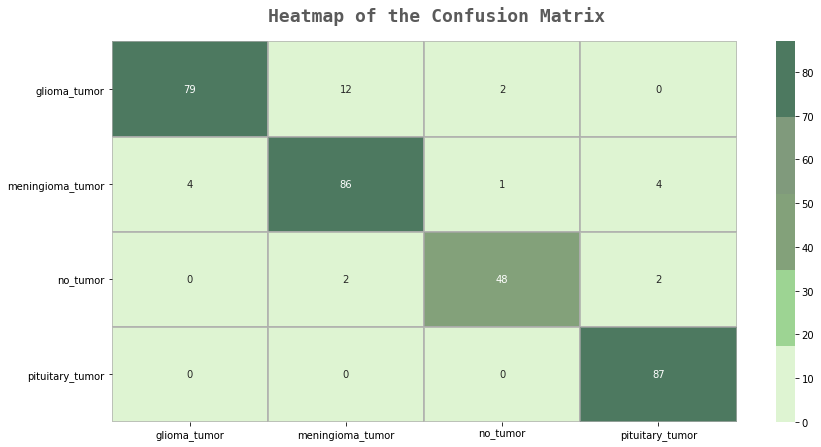

In [91]:
fig,ax=plt.subplots(1,1,figsize=(14,7))
sns.heatmap(confusion_matrix(y_test_new,pred),ax=ax,xticklabels=labels,yticklabels=labels,annot=True,
           cmap=colors_green[::-1],alpha=0.7,linewidths=2,linecolor=colors_dark[3])
fig.text(s='Heatmap of the Confusion Matrix',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=0.92,x=0.28,alpha=0.8)

plt.show()

In [65]:
test_pred = cnn.predict(X_test_scaled)
test_pred = np.argmax(test_pred, axis=1)
Y_test_ = np.argmax(y_test, axis=1)
print("Accuracy on testing set: {:.2f}%".format(np.sum(test_pred==Y_test_)/len(Y_test_)*100))

Accuracy on testing set: 87.76%


In [69]:
train_pred = cnn.predict(X_train_scaled)
train_pred = np.argmax(train_pred, axis=1)
Y_train_ = np.argmax(y_train, axis=1)
print("Accuracy on training set: {:.2f}%".format(np.sum(train_pred==Y_train_)/len(Y_train_)*100))

Accuracy on training set: 93.68%


In [70]:
#def img_pred(upload):
for name, file_info in uploader.value.items():
    img = Image.open(io.BytesIO(file_info['content']))
opencvImage = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
img = cv2.resize(opencvImage,(150,150))
img = img.reshape(1,150,150,3)
print(img)


[[[[ 7  7  7]
   [ 8  8  8]
   [ 6  6  6]
   ...
   [10 10 10]
   [16 16 16]
   [18 18 18]]

  [[ 6  6  6]
   [11 11 11]
   [15 15 15]
   ...
   [ 8  8  8]
   [12 12 12]
   [24 24 24]]

  [[ 7  7  7]
   [ 9  9  9]
   [13 13 13]
   ...
   [24 24 24]
   [29 29 29]
   [25 25 25]]

  ...

  [[ 4  4  4]
   [19 19 19]
   [25 25 25]
   ...
   [24 24 24]
   [16 16 16]
   [14 14 14]]

  [[ 9  9  9]
   [21 21 21]
   [25 25 25]
   ...
   [12 12 12]
   [12 12 12]
   [14 14 14]]

  [[15 15 15]
   [22 22 22]
   [29 29 29]
   ...
   [14 14 14]
   [13 13 13]
   [21 21 21]]]]


In [71]:
p = cnn.predict(img)
p = np.argmax(p,axis=1)[0]
print(p)
if p==0:
    p='Glioma Tumor'
elif p==1:
    print('The model predicts that there is no tumor')
elif p==2:
    p='Meningioma Tumor'
else:
    p='Pituitary Tumor'

if p!=1:
    print(f'The Model predicts that it is a {p}')


1
The model predicts that there is no tumor


In [5]:
import ipywidgets as widgets
uploader = widgets.FileUpload()
display(uploader)

FileUpload(value={}, description='Upload')

In [6]:
button = widgets.Button(description='Predict')
out = widgets.Output()
def on_button_clicked(_):
    with out:
        clear_output()
        try:
            p = img_pred(uploader)
            print(p)
            
        except:
            print('No Image Uploaded/Invalid Image File')
button.on_click(on_button_clicked)
widgets.VBox([button,out])

In [116]:
#vedo con lo zooming che cosa succede
data_augmentation = keras.Sequential([
        
        layers.experimental.preprocessing.RandomFlip("horizontal", input_shape= (image_size,image_size,3)),
        #layers.experimental.preprocessing.RandomRotation(factor=(-0.2,0.2))
        layers.experimental.preprocessing.RandomZoom(height_factor=(0.2, 0.3))
    ])


In [117]:
cnn.fit(X_train_scaled, y_train, epochs = 30, validation_split = 0.1, batch_size=32,callbacks=[tensorboard, checkpoint, reduce_lr])

Epoch 1/30
83/83 [==============================] - ETA: 0s - loss: 0.1755 - accuracy: 0.9342
Epoch 00001: val_accuracy did not improve from 0.92857
83/83 [==============================] - 27s 323ms/step - loss: 0.1755 - accuracy: 0.9342 - val_loss: 0.2447 - val_accuracy: 0.9218
Epoch 2/30
83/83 [==============================] - ETA: 0s - loss: 0.1546 - accuracy: 0.9414
Epoch 00002: val_accuracy did not improve from 0.92857
83/83 [==============================] - 30s 364ms/step - loss: 0.1546 - accuracy: 0.9414 - val_loss: 0.2449 - val_accuracy: 0.9218
Epoch 3/30
83/83 [==============================] - ETA: 0s - loss: 0.1694 - accuracy: 0.9398
Epoch 00003: val_accuracy did not improve from 0.92857

Epoch 00003: ReduceLROnPlateau reducing learning rate to 7.289999985005124e-07.
83/83 [==============================] - 32s 381ms/step - loss: 0.1694 - accuracy: 0.9398 - val_loss: 0.2445 - val_accuracy: 0.9218
Epoch 4/30
83/83 [==============================] - ETA: 0s - loss: 0.1590 -

Epoch 27/30
83/83 [==============================] - ETA: 0s - loss: 0.1662 - accuracy: 0.9402
Epoch 00027: val_accuracy did not improve from 0.92857

Epoch 00027: ReduceLROnPlateau reducing learning rate to 3.874204993273289e-13.
83/83 [==============================] - 28s 342ms/step - loss: 0.1662 - accuracy: 0.9402 - val_loss: 0.2445 - val_accuracy: 0.9218
Epoch 28/30
83/83 [==============================] - ETA: 0s - loss: 0.1644 - accuracy: 0.9410
Epoch 00028: val_accuracy did not improve from 0.92857
83/83 [==============================] - 31s 371ms/step - loss: 0.1644 - accuracy: 0.9410 - val_loss: 0.2445 - val_accuracy: 0.9218
Epoch 29/30
83/83 [==============================] - ETA: 0s - loss: 0.1611 - accuracy: 0.9395
Epoch 00029: val_accuracy did not improve from 0.92857

Epoch 00029: ReduceLROnPlateau reducing learning rate to 1.162261530508052e-13.
83/83 [==============================] - 28s 340ms/step - loss: 0.1611 - accuracy: 0.9395 - val_loss: 0.2445 - val_accuracy:

<AxesSubplot:>

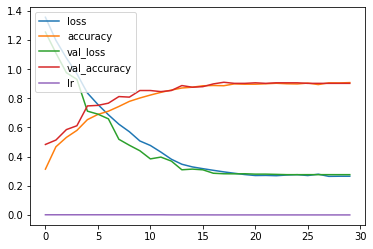

In [55]:
pd.DataFrame(cnn.history.history).plot()

In [56]:
preds = cnn.predict(X_test_scaled,verbose=1)

D:\Users\franc\anaconda3\envs\tensorflow_env\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py:3349: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


10/10 [==============================] - 1s 125ms/step


In [57]:
print(preds)

[[6.3042417e-02 4.2363778e-02 8.9141393e-01 3.1798226e-03]
 [2.4556985e-01 3.8740495e-01 4.4086508e-02 3.2293865e-01]
 [3.2284025e-03 1.0193546e-01 3.5960312e-04 8.9447659e-01]
 ...
 [1.1492656e-03 9.9884450e-01 2.0259445e-06 4.1316184e-06]
 [1.8788116e-02 1.2990691e-02 9.6802473e-01 1.9636955e-04]
 [3.2002158e-02 6.9086142e-02 8.9804572e-01 8.6596742e-04]]


In [60]:
print(X_test_scaled)
X_test_scaled.shape

[[[[0.10980392 0.10980392 0.10980392]
   [0.12156863 0.12156863 0.12156863]
   [0.12156863 0.12156863 0.12156863]
   ...
   [0.1254902  0.1254902  0.1254902 ]
   [0.12941176 0.12941176 0.12941176]
   [0.12941176 0.12941176 0.12941176]]

  [[0.10980392 0.10980392 0.10980392]
   [0.12156863 0.12156863 0.12156863]
   [0.12156863 0.12156863 0.12156863]
   ...
   [0.12156863 0.12156863 0.12156863]
   [0.12156863 0.12156863 0.12156863]
   [0.12156863 0.12156863 0.12156863]]

  [[0.10980392 0.10980392 0.10980392]
   [0.12156863 0.12156863 0.12156863]
   [0.11764706 0.11764706 0.11764706]
   ...
   [0.11764706 0.11764706 0.11764706]
   [0.11764706 0.11764706 0.11764706]
   [0.11764706 0.11764706 0.11764706]]

  ...

  [[0.10980392 0.10980392 0.10980392]
   [0.11372549 0.11372549 0.11372549]
   [0.11764706 0.11764706 0.11764706]
   ...
   [0.12156863 0.12156863 0.12156863]
   [0.12156863 0.12156863 0.12156863]
   [0.12156863 0.12156863 0.12156863]]

  [[0.10980392 0.10980392 0.10980392]
   [0.1

(294, 150, 150, 3)

In [62]:
X_test.reset()
x=np.concatenate([X_test.next()[0] for i in range(X_test.__len__())])
y=np.concatenate([X_test.next()[1] for i in range(X_test.__len__())])
print(x.shape)
print(y.shape)
#this little code above extracts the images from test Data iterator without shuffling the sequence
# x contains image array and y has labels 
dic = {0:'GLIOMA', 1:'MENINGIOMA',2:'NO TUMOR',3:'PITUITARIO'}
plt.figure(figsize=(20,20))
for i in range(0+228, 9+228):
  plt.subplot(3, 3, (i-228)+1)
  if preds[i, 0] >= 0.5: 
      out = ('{:.2%} probability of being Pneumonia case'.format(preds[i][0]))
      
      
  else: 
      out = ('{:.2%} probability of being Normal case'.format(1-preds[i][0]))
      plt.title(out+"\n Actual case : "+ dic.get(y[i]))    
  plt.imshow(np.squeeze(x[i]))
  plt.axis('off')
plt.show()

AttributeError: 'numpy.ndarray' object has no attribute 'next'

In [52]:
#a different model with 4 conv layers (no augmentation)
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization

cnn4 = Sequential()
cnn4.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(image_size,image_size,3)))
cnn4.add(BatchNormalization())

cnn4.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
cnn4.add(BatchNormalization())
cnn4.add(MaxPooling2D(pool_size=(2, 2)))
cnn4.add(Dropout(0.25))

cnn4.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
cnn4.add(BatchNormalization())
cnn4.add(Dropout(0.25))

cnn4.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
cnn4.add(BatchNormalization())
cnn4.add(MaxPooling2D(pool_size=(2, 2)))
cnn4.add(Dropout(0.25))

cnn4.add(Flatten())

cnn4.add(Dense(512, activation='relu'))
cnn4.add(BatchNormalization())
cnn4.add(Dropout(0.5))

cnn4.add(Dense(128, activation='relu'))
cnn4.add(BatchNormalization())
cnn4.add(Dropout(0.5))
cnn4.add(Dense(4, activation='softmax'))

cnn4.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

In [53]:
cnn4.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_31 (Conv2D)           (None, 148, 148, 32)      896       
_________________________________________________________________
batch_normalization_30 (Batc (None, 148, 148, 32)      128       
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 146, 146, 32)      9248      
_________________________________________________________________
batch_normalization_31 (Batc (None, 146, 146, 32)      128       
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 73, 73, 32)        0         
_________________________________________________________________
dropout_28 (Dropout)         (None, 73, 73, 32)        0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 71, 71, 64)      

In [94]:

checkpoint = ModelCheckpoint("brain_tumor_best_model{epoch:30}.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 2, min_delta = 0.001,
                              mode='auto',verbose=1)


In [95]:
cnn4.fit(X_train_scaled, y_train, epochs = 30, validation_split = 0.1, batch_size=32,callbacks=[ checkpoint, reduce_lr])

Epoch 1/30
75/75 [==============================] - ETA: 0s - loss: 0.0549 - accuracy: 0.9823
Epoch 00001: val_accuracy improved from -inf to 0.89057, saving model to brain_tumor_best_model                             1.h5
75/75 [==============================] - 218s 3s/step - loss: 0.0549 - accuracy: 0.9823 - val_loss: 0.3193 - val_accuracy: 0.8906
Epoch 2/30
75/75 [==============================] - ETA: 0s - loss: 0.0546 - accuracy: 0.9823
Epoch 00002: val_accuracy did not improve from 0.89057
75/75 [==============================] - 215s 3s/step - loss: 0.0546 - accuracy: 0.9823 - val_loss: 0.3205 - val_accuracy: 0.8906
Epoch 3/30
 6/75 [=>............................] - ETA: 2:48 - loss: 0.0809 - accuracy: 0.9740

KeyboardInterrupt: 

In [58]:
pred = cnn4.predict(X_test_scaled)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)
print(pred)
print(y_test_new)

[2 0 3 3 3 0 1 0 2 1 3 0 1 3 0 3 2 2 3 1 3 3 1 3 2 3 2 0 1 1 0 0 0 3 0 3 3
 3 3 3 0 0 3 0 1 3 0 3 1 0 1 3 1 2 3 1 2 2 0 3 2 1 3 2 2 1 1 0 1 3 1 0 3 1
 2 0 1 0 3 1 0 2 0 3 3 2 0 3 3 0 0 1 0 1 1 1 3 1 0 2 0 1 1 0 1 0 0 2 2 3 3
 0 1 0 1 2 1 0 2 1 2 3 1 3 0 1 2 3 0 3 1 3 3 0 0 0 3 2 3 0 1 3 3 0 3 0 0 3
 2 1 3 3 3 0 0 0 3 1 1 1 1 1 2 1 1 1 3 0 0 1 1 3 0 2 3 0 0 0 0 1 3 0 2 2 0
 0 0 3 0 0 0 2 1 3 2 1 3 1 2 1 0 2 3 1 0 0 2 3 2 2 0 1 1 2 3 1 1 2 0 0 0 0
 3 0 0 0 0 3 2 3 3 3 0 2 1 1 0 3 3 2 3 0 3 2 0 1 1 3 2 1 0 3 3 0 1 3 3 0 1
 0 0 1 1 3 3 3 2 0 3 3 0 3 1 0 1 0 3 1 0 2 3 0 1 1 2 0 2 2 1 0 1 1 2 2]
[2 0 3 3 3 0 1 0 2 0 3 0 1 3 0 3 2 2 3 1 3 3 2 3 2 3 2 0 1 1 0 0 0 3 0 3 3
 3 3 3 1 0 3 0 1 3 0 3 1 0 2 3 1 2 3 1 2 2 0 3 2 1 3 2 2 1 1 0 1 3 1 0 3 1
 2 0 1 0 3 0 0 2 0 3 3 2 0 3 3 0 1 1 0 1 1 1 3 1 0 2 0 0 1 1 1 0 0 2 0 3 3
 0 1 0 1 2 0 0 2 1 0 3 1 3 0 1 1 3 0 3 1 3 3 0 0 1 3 1 3 0 1 3 3 0 3 0 0 3
 2 1 3 3 3 0 0 1 3 1 1 0 0 1 2 1 1 1 3 0 0 1 1 3 0 2 3 0 0 1 0 1 1 0 2 2 0
 0 0 3 0 0 0 2 1 3 2 1 3 1 2

In [67]:
test_pred = cnn4.predict(X_test_scaled)
test_pred = np.argmax(test_pred, axis=1)
Y_test_ = np.argmax(y_test, axis=1)
print("Accuracy on testing set: {:.2f}%".format(np.sum(test_pred==Y_test_)/len(Y_test_)*100))

Accuracy on testing set: 91.84%


In [68]:
train_pred = cnn4.predict(X_train_scaled)
train_pred = np.argmax(train_pred, axis=1)
Y_train_ = np.argmax(y_train, axis=1)
print("Accuracy on training set: {:.2f}%".format(np.sum(train_pred==Y_train_)/len(Y_train_)*100))

Accuracy on training set: 98.37%


In [79]:
#a different model with 4 conv layers without augmenting
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(image_size,image_size,3)))
model.add(BatchNormalization())

model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(4, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])
#faccio un fitting con un validation set differente
model.fit(X_train_scaled, y_train, epochs = 50, validation_data = (X_test_scaled,y_test), batch_size=32,callbacks=[tensorboard, checkpoint, reduce_lr])
#Qui occorre vedere come è aumentata l'accuracy e la val_accuracy via via (la val_accuracy migliore è di training precedenti per lo stesso modello)

Epoch 1/50
83/83 [==============================] - ETA: 0s - loss: 1.2772 - accuracy: 0.5664
Epoch 00001: val_accuracy did not improve from 0.92830
83/83 [==============================] - 340s 4s/step - loss: 1.2772 - accuracy: 0.5664 - val_loss: 4.8758 - val_accuracy: 0.1599
Epoch 2/50
83/83 [==============================] - ETA: 0s - loss: 0.8732 - accuracy: 0.6879
Epoch 00002: val_accuracy did not improve from 0.92830
83/83 [==============================] - 234s 3s/step - loss: 0.8732 - accuracy: 0.6879 - val_loss: 2.2420 - val_accuracy: 0.3333
Epoch 3/50
83/83 [==============================] - ETA: 0s - loss: 0.6151 - accuracy: 0.7768
Epoch 00003: val_accuracy did not improve from 0.92830
83/83 [==============================] - 228s 3s/step - loss: 0.6151 - accuracy: 0.7768 - val_loss: 1.4268 - val_accuracy: 0.3129
Epoch 4/50
83/83 [==============================] - ETA: 0s - loss: 0.5143 - accuracy: 0.8116
Epoch 00004: val_accuracy did not improve from 0.92830
83/83 [=======

Epoch 28/50
83/83 [==============================] - ETA: 0s - loss: 0.0408 - accuracy: 0.9894
Epoch 00028: val_accuracy did not improve from 0.92830
83/83 [==============================] - 239s 3s/step - loss: 0.0408 - accuracy: 0.9894 - val_loss: 0.2735 - val_accuracy: 0.9116
Epoch 29/50
83/83 [==============================] - ETA: 0s - loss: 0.0399 - accuracy: 0.9886
Epoch 00029: val_accuracy did not improve from 0.92830

Epoch 00029: ReduceLROnPlateau reducing learning rate to 5.904900035602622e-09.
83/83 [==============================] - 237s 3s/step - loss: 0.0399 - accuracy: 0.9886 - val_loss: 0.2731 - val_accuracy: 0.9116
Epoch 30/50
83/83 [==============================] - ETA: 0s - loss: 0.0377 - accuracy: 0.9879
Epoch 00030: val_accuracy did not improve from 0.92830
83/83 [==============================] - 236s 3s/step - loss: 0.0377 - accuracy: 0.9879 - val_loss: 0.2727 - val_accuracy: 0.9116
Epoch 31/50
81/83 [============================>.] - ETA: 5s - loss: 0.0423 - a

KeyboardInterrupt: 

In [99]:
model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_39 (Conv2D)           (None, 148, 148, 32)      896       
_________________________________________________________________
batch_normalization_42 (Batc (None, 148, 148, 32)      128       
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 146, 146, 32)      9248      
_________________________________________________________________
batch_normalization_43 (Batc (None, 146, 146, 32)      128       
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 73, 73, 32)        0         
_________________________________________________________________
dropout_38 (Dropout)         (None, 73, 73, 32)        0         
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 71, 71, 64)      

In [84]:
model.save('model92%valaccuracy.h5')

In [85]:
new_model = tf.keras.models.load_model('model92%valaccuracy.h5')
new_model.evaluate(X_test_scaled,y_test)

10/10 [==============================] - 4s 396ms/step - loss: 0.2729 - accuracy: 0.9116


[0.2729130983352661, 0.9115646481513977]

In [96]:
checkpoint2 = ModelCheckpoint("brain_tumor_best_model_augmented{epoch:30}.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)


In [98]:
#the same model above with augmentation
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization

Model = Sequential([data_augmentation])
Model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(image_size,image_size,3)))
Model.add(BatchNormalization())

Model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
Model.add(BatchNormalization())
Model.add(MaxPooling2D(pool_size=(2, 2)))
Model.add(Dropout(0.25))

Model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
Model.add(BatchNormalization())
Model.add(Dropout(0.25))

Model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
Model.add(BatchNormalization())
Model.add(MaxPooling2D(pool_size=(2, 2)))
Model.add(Dropout(0.25))

Model.add(Flatten())

Model.add(Dense(512, activation='relu'))
Model.add(BatchNormalization())
Model.add(Dropout(0.5))

Model.add(Dense(128, activation='relu'))
Model.add(BatchNormalization())
Model.add(Dropout(0.5))
Model.add(Dense(4, activation='softmax'))

Model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])
#faccio un fitting con un validation set differente
Model.fit(X_train_scaled, y_train, epochs = 30, validation_data = (X_test_scaled,y_test), batch_size=32,callbacks=[ checkpoint2, reduce_lr])
#qui il modello è stato salvato in un file riservato al data augmentation

Epoch 1/30
83/83 [==============================] - ETA: 0s - loss: 1.3758 - accuracy: 0.5498
Epoch 00001: val_accuracy improved from -inf to 0.27211, saving model to brain_tumor_best_model_augmented                             1.h5
83/83 [==============================] - 248s 3s/step - loss: 1.3758 - accuracy: 0.5498 - val_loss: 11.7232 - val_accuracy: 0.2721
Epoch 2/30
83/83 [==============================] - ETA: 0s - loss: 1.0310 - accuracy: 0.6330
Epoch 00002: val_accuracy did not improve from 0.27211
83/83 [==============================] - 244s 3s/step - loss: 1.0310 - accuracy: 0.6330 - val_loss: 11.7322 - val_accuracy: 0.2721
Epoch 3/30
83/83 [==============================] - ETA: 0s - loss: 0.9175 - accuracy: 0.6644
Epoch 00003: val_accuracy improved from 0.27211 to 0.27891, saving model to brain_tumor_best_model_augmented                             3.h5
83/83 [==============================] - 244s 3s/step - loss: 0.9175 - accuracy: 0.6644 - val_loss: 8.4202 - val_accurac

In [ ]:
checkpoint3 = ModelCheckpoint("brain_tumor_best_model_augmented{epoch:30}.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)


In [107]:
pred2 = Model.predict(X_test_scaled)
pred2 = np.argmax(pred2,axis=1)
y_test_new = np.argmax(y_test,axis=1)
print(pred2)
print(y_test_new)


[2 0 3 3 3 0 3 0 2 0 3 0 0 3 0 3 1 2 3 1 3 3 0 3 2 3 2 0 1 1 0 0 0 3 0 3 3
 3 3 3 0 3 3 0 0 3 0 3 1 0 1 3 0 3 3 0 2 2 0 3 2 1 3 2 2 1 0 0 3 3 0 0 3 1
 2 0 1 0 3 1 0 2 0 3 3 2 0 3 3 0 0 2 0 0 1 1 3 1 0 2 0 0 3 0 1 0 0 2 2 3 3
 0 0 0 1 2 1 0 2 1 2 2 1 3 0 3 1 3 0 3 0 3 3 0 0 0 3 1 3 0 1 3 3 0 3 0 0 3
 2 1 3 3 3 0 0 0 3 1 0 0 1 1 2 3 1 1 3 0 0 1 1 3 0 2 3 0 0 1 0 1 1 2 2 3 0
 0 0 3 0 0 0 2 0 3 2 1 3 1 2 1 0 2 3 0 0 0 2 3 2 2 0 0 1 2 3 3 1 2 0 0 0 0
 3 0 0 2 0 3 2 3 3 3 0 2 1 1 0 3 3 2 3 0 3 2 0 1 1 3 2 1 0 3 3 0 3 3 3 0 1
 0 0 1 0 3 3 3 2 0 3 3 0 3 1 0 1 0 3 1 0 2 3 0 0 1 2 0 2 2 1 0 1 1 2 2]
[2 0 3 3 3 0 1 0 2 0 3 0 1 3 0 3 2 2 3 1 3 3 2 3 2 3 2 0 1 1 0 0 0 3 0 3 3
 3 3 3 1 0 3 0 1 3 0 3 1 0 2 3 1 2 3 1 2 2 0 3 2 1 3 2 2 1 1 0 1 3 1 0 3 1
 2 0 1 0 3 0 0 2 0 3 3 2 0 3 3 0 1 1 0 1 1 1 3 1 0 2 0 0 1 1 1 0 0 2 0 3 3
 0 1 0 1 2 0 0 2 1 0 3 1 3 0 1 1 3 0 3 1 3 3 0 0 1 3 1 3 0 1 3 3 0 3 0 0 3
 2 1 3 3 3 0 0 1 3 1 1 0 0 1 2 1 1 1 3 0 0 1 1 3 0 2 3 0 0 1 0 1 1 0 2 2 0
 0 0 3 0 0 0 2 1 3 2 1 3 1 2

In [108]:
#report di classificazione
print(classification_report(y_test_new,pred2))

              precision    recall  f1-score   support

           0       0.80      0.89      0.84        93
           1       0.88      0.62      0.73        74
           2       0.85      0.87      0.86        47
           3       0.88      0.99      0.93        80

    accuracy                           0.85       294
   macro avg       0.85      0.84      0.84       294
weighted avg       0.85      0.85      0.84       294



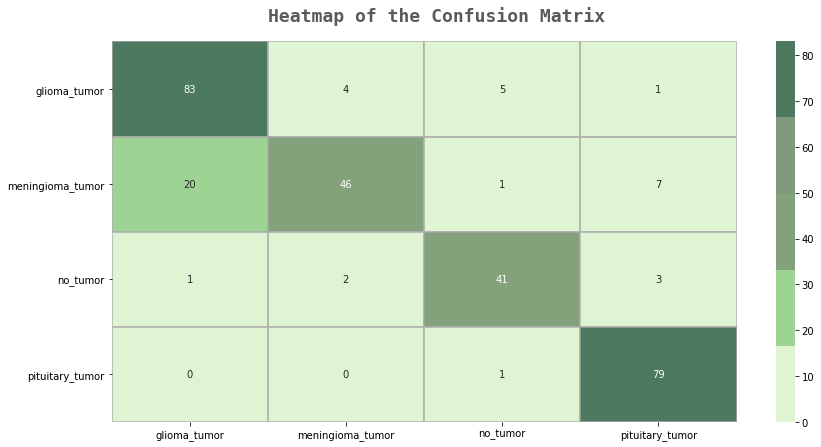

In [111]:
fig,ax=plt.subplots(1,1,figsize=(14,7))
sns.heatmap(confusion_matrix(y_test_new,pred2),ax=ax,xticklabels=labels,yticklabels=labels,annot=True,
           cmap=colors_green[::-1],alpha=0.7,linewidths=2,linecolor=colors_dark[3])
fig.text(s='Heatmap of the Confusion Matrix',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=0.92,x=0.28,alpha=0.8)

plt.show()

In [135]:
model = Sequential([data_augmentation])
model.add(Conv2D(input_shape=(224,224,3),
filters=64,kernel_size=(3,3),
padding="same", activation="relu"))
model.add(Conv2D(filters=64,kernel_size=(3,3),
padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))

model.add(Conv2D(filters=128, kernel_size=(3,3),
padding="same", activation="relu"))
model.add(Conv2D(filters=128, kernel_size=(3,3),
padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))

model.add(Conv2D(filters=256, kernel_size=(3,3),
padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3),
padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3),
padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))

model.add(Conv2D(filters=512, kernel_size=(3,3),
padding="same",activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3),
padding="same",activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3),
padding="same",activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))

model.add(Conv2D(filters=512, kernel_size=(3,3),
padding="same",activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3),
padding="same",activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3),
padding="same",activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))

model.add(Flatten())
model.add(Dense(units=4096,activation="relu"))
model.add(Dense(units=4096,activation="relu"))
model.add(Dense(units=4, activation="softmax"))
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])
model.summary()

Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_9 (Sequential)    (None, 150, 150, 3)       0         
_________________________________________________________________
conv2d_199 (Conv2D)          (None, 150, 150, 64)      1792      
_________________________________________________________________
conv2d_200 (Conv2D)          (None, 150, 150, 64)      36928     
_________________________________________________________________
max_pooling2d_94 (MaxPooling (None, 75, 75, 64)        0         
_________________________________________________________________
conv2d_201 (Conv2D)          (None, 75, 75, 128)       73856     
_________________________________________________________________
conv2d_202 (Conv2D)          (None, 75, 75, 128)       147584    
_________________________________________________________________
max_pooling2d_95 (MaxPooling (None, 37, 37, 128)     

In [136]:
checkpoint4 = ModelCheckpoint("brain_tumor_best_model_VGG{epoch:50}.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)


In [137]:
model.fit(X_train_scaled, y_train, epochs = 15, validation_data = (X_test_scaled,y_test), batch_size=32,callbacks=[ checkpoint4, reduce_lr])


Epoch 1/15
83/83 [==============================] - ETA: 0s - loss: 1.4041 - accuracy: 0.2777 
Epoch 00001: val_accuracy improved from -inf to 0.25170, saving model to brain_tumor_best_model_VGG                                                 1.h5
83/83 [==============================] - 1167s 14s/step - loss: 1.4041 - accuracy: 0.2777 - val_loss: 1.3650 - val_accuracy: 0.2517
Epoch 2/15
83/83 [==============================] - ETA: 0s - loss: 1.3616 - accuracy: 0.2671 
Epoch 00002: val_accuracy did not improve from 0.25170
83/83 [==============================] - 1247s 15s/step - loss: 1.3616 - accuracy: 0.2671 - val_loss: 1.3629 - val_accuracy: 0.2517
Epoch 3/15
83/83 [==============================] - ETA: 0s - loss: 1.3607 - accuracy: 0.2788 
Epoch 00003: val_accuracy improved from 0.25170 to 0.27211, saving model to brain_tumor_best_model_VGG                                                 3.h5
83/83 [==============================] - 2524s 30s/step - loss: 1.3607 - accuracy: 0.27

KeyboardInterrupt: 